Installing all needed libraries:

In [1]:
!pip install -U textblob-de
!python -m textblob.download_corpora
!pip install vaderSentiment
!pip install WordCloud
!pip install pycountry
!pip install langdetect
!pip install vader-multi
!pip install -U textblob
!pip install pandarallel
!pip install swifter


Requirement already up-to-date: textblob-de in c:\users\lukas\anaconda3\lib\site-packages (0.4.3)
Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!

Requirement already up-to-date: textblob in c:\users\lukas\anaconda3\lib\site-packages (0.15.3)


Importing all relevant libraries:

In [2]:
import sqlite3
from PIL import Image
import swifter
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import sqlite3
import time
import string 
#from googletrans import Translator
import pandas as pd
import numpy as np
import json
import pandas as pd
import os
import numpy as np
import re
import pycountry
from typing import List
import nltk
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from pandarallel import pandarallel
pandarallel.initialize()

ValueError: cannot find context for 'fork'

Create running time optimized functions:

In [3]:
def textsubjectivity(df):
    return df.parallel_apply(
    lambda row: TextBlob(
      row).sentiment.subjectivity
  )

In [4]:
def textpolarity(df):
    return df.parallel_apply(
    lambda row: TextBlob(
      row).sentiment.polarity
  )

In [5]:
sia = SentimentIntensityAnalyzer()
def swifter_impl(df):
    return df.swifter.apply(
    lambda row: sia.polarity_scores(
    row))


Open up the database and select all Tweets:

In [7]:
conn_tweets = sqlite3.connect('tweets_airlines.db')

In [8]:
query = '''SELECT *
           FROM TWEETS
           '''

df_tweets = pd.read_sql(query, conn_tweets)

Add subjectivity, polarity via textblob:

In [ ]:
df_tweets['subjectivity'] = textsubjectivity(df_tweets['full_text'])


In [ ]:
df_tweets['polarity'] = textpolarity(df_tweets['full_text'])


Add other semantic features via Vader:

In [ ]:
df_tweets = (pd.json_normalize(swifter_impl(df_tweets["full_text"]))).join(df_tweets)

In [ ]:
df_tweets.to_sql('TWEETS', conn_tweets, if_exists="replace", index=False)

In [ ]:
conn_tweets.close()

In [ ]:
conn_tweets = sqlite3.connect('tweets_airlines.db')

In [ ]:
query = '''SELECT *
           FROM TWEETS
           '''

df_tweets = pd.read_sql(query, conn_tweets)

Create a new dataframe and classify the Tweets with negative,positive or neutral:

In [ ]:
df_sentiments = df_tweets[['tweet_id', 'full_text', 'subjectivity', 'polarity', 'compound', 'neg', 'neu', 'pos']]

In [ ]:
df_sentiments['sentiment'] = df_sentiments[df_sentiments['neg'] != df_sentiments['pos']][['neg', 'pos']].idxmax(axis=1)
df_sentiments['sentiment'].fillna('neu', inplace=True)




In [ ]:
tw_list_negative = df_sentiments[df_sentiments["sentiment"]=="neg"]
tw_list_positive = df_sentiments[df_sentiments["sentiment"]=="pos"]
tw_list_neutral = df_sentiments[df_sentiments["sentiment"]=="neu"]

Create different word clouds for sentiments:

In [ ]:
def create_wordcloud(text):
    mask = np.array(Image.open("cloud.jpg"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))


In [ ]:
create_wordcloud(tw_list_positive["full_text"].values)

In [ ]:
create_wordcloud(tw_list_negative["full_text"].values)


In [ ]:
tw_list = df_sentiments

Calculate the character length of each sentiment:

In [ ]:
tw_list["text_len"] = tw_list["full_text"].astype(str).apply(len)
tw_list["text_word_count"] = tw_list["full_text"].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(tw_list.groupby("sentiment").text_len.mean()),2)

Calculate the word count per sentiment:

In [ ]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_word_count.mean()),2)

Remove punctuation, stopwords etc:


In [ ]:
def remove_punct(text):
 text = "".join([char for char in text if char not in string.punctuation])
 text = re.sub('[0–9]+', '', text)
 return text
tw_list["punct"] = tw_list["full_text"].apply(lambda x: remove_punct(x))
#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
tw_list['tokenized'] = tw_list['punct'].apply(lambda x: tokenization(x.lower()))
#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))
#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
tw_list.head()

In [ ]:
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tw_list["full_text"])
print("{} Number of reviews has {} words".format(countVector.shape[0], countVector.shape[1]))
print(countVectorizer.get_feature_names())


In [9]:
query = '''SELECT *
           FROM TWEETS
           WHERE user_id =  56377143
           '''

df_tweets_klm = pd.read_sql(query, conn_tweets)

In [ ]:
query = '''SELECT *
           FROM TWEETS
           EXCEPT 
           SELECT *
           FROM TWEETS
           WHERE user_id =  56377143

           '''

df_tweets_comp = pd.read_sql(query, conn_tweets)

In [10]:
df_sentiments_klm = df_tweets_klm[['tweet_id', 'full_text', 'subjectivity', 'polarity', 'compound', 'neg', 'neu', 'pos']]
df_sentiments_comp = df_tweets_comp[['tweet_id', 'full_text', 'subjectivity', 'polarity', 'compound', 'neg', 'neu', 'pos']]


In [ ]:
df_sentiments_comp['sentiment'] = df_sentiments_comp[df_sentiments_comp['neg'] != df_sentiments_comp['pos']][['neg', 'pos']].idxmax(axis=1)
df_sentiments_comp['sentiment'].fillna('neu', inplace=True)




In [11]:
df_sentiments_klm['sentiment'] = df_sentiments_klm[df_sentiments_klm['neg'] != df_sentiments_klm['pos']][['neg', 'pos']].idxmax(axis=1)
df_sentiments_klm['sentiment'].fillna('neu', inplace=True)




<ipython-input-11-a47a62fcaf44>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiments_klm['sentiment'] = df_sentiments_klm[df_sentiments_klm['neg'] != df_sentiments_klm['pos']][['neg', 'pos']].idxmax(axis=1)
C:\Users\lukas\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [ ]:
tw_list_negative_comp = df_sentiments_comp[df_sentiments_comp["sentiment"]=="neg"]
tw_list_positive_comp = df_sentiments_comp[df_sentiments_comp["sentiment"]=="pos"]
tw_list_neutral_comp = df_sentiments_comp[df_sentiments_comp["sentiment"]=="neu"]

In [12]:
tw_list_negative_klm = df_sentiments_klm[df_sentiments_klm["sentiment"]=="neg"]
tw_list_positive_klm = df_sentiments_klm[df_sentiments_klm["sentiment"]=="pos"]
tw_list_neutral_klm = df_sentiments_klm[df_sentiments_klm["sentiment"]=="neu"]

In [ ]:
# library
import matplotlib.pyplot as plt

# create data
size_of_groups=[len(tw_list_positive_comp),len(tw_list_negative_comp)]

labels= ['Positive Tweets', 'Negative Tweets']

# Create a pieplot
fig = plt.pie(size_of_groups, labels = labels, autopct='%0.1f%%')

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.43,color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.savefig("PieChartCompetitors.png")




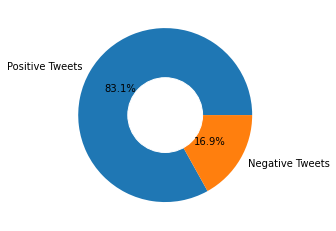

In [14]:
# library

import matplotlib.pyplot as plt

# create data
size_of_groups=[len(tw_list_positive_klm),len(tw_list_negative_klm)]

labels= ['Positive Tweets', 'Negative Tweets']

# Create a pieplot
plt.pie(size_of_groups, labels = labels, autopct='%0.1f%%')

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.43,color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig("PieChartKLM.png")
plt.show()

In [ ]:
conn_tweets.close()